In [2]:
!pip install pyspark

     |████████████████████████████████| 204.7MB 66kB/s 
     |████████████████████████████████| 204kB 19.9MB/s 
  Created wheel for pyspark: filename=pyspark-3.0.0-py2.py3-none-any.whl size=205044182 sha256=2dc319bad8ba62c99f61e7488d00a41a8c4ceae159067e2c865b4429035559a0
  Stored in directory: /root/.cache/pip/wheels/57/27/4d/ddacf7143f8d5b76c45c61ee2e43d9f8492fc5a8e78ebd7d37
Successfully built pyspark


In [3]:
#Initialize SparkSession and SparkContext
from pyspark.sql import SparkSession
from pyspark import SparkContext

In [4]:
#Create a Spark Session
SpSession = SparkSession.builder.master("local[*]").getOrCreate()

In [5]:
#Get the Spark Context from Spark Session    
SpContext = SpSession.sparkContext

In [15]:
#Load the CSV file into a RDD
autoData = SpContext.textFile("/content/drive/My Drive/auto-data.csv")
autoData.cache()

#Remove the first line (contains headers)
firstLine = autoData.first()
dataLines = autoData.filter(lambda x: x != firstLine)
dataLines.count()


197

In [16]:
from pyspark.sql import Row

import math
from pyspark.ml.linalg import Vectors

#Convert to Local Vector.
def transformToNumeric( inputStr) :
    attList=inputStr.split(",")

    doors = 1.0 if attList[3] =="two" else 2.0
    body = 1.0 if attList[4] == "sedan" else 2.0 
       
    #Filter out columns not wanted at this stage
    values= Row(DOORS= doors, \
                     BODY=float(body),  \
                     HP=float(attList[7]),  \
                     RPM=float(attList[8]),  \
                     MPG=float(attList[9])  \
                     )
    return values

autoMap = dataLines.map(transformToNumeric)
autoMap.persist()
autoMap.collect()

autoDf = SpSession.createDataFrame(autoMap)
autoDf.show()


+-----+----+----+------+----+
|DOORS|BODY|  HP|   RPM| MPG|
+-----+----+----+------+----+
|  1.0| 2.0|69.0|4900.0|31.0|
|  1.0| 2.0|48.0|5100.0|47.0|
|  1.0| 2.0|68.0|5000.0|30.0|
|  1.0| 2.0|62.0|4800.0|35.0|
|  1.0| 2.0|68.0|5500.0|37.0|
|  1.0| 2.0|60.0|5500.0|38.0|
|  1.0| 1.0|69.0|5200.0|31.0|
|  1.0| 2.0|68.0|5500.0|37.0|
|  1.0| 2.0|68.0|5500.0|37.0|
|  1.0| 2.0|68.0|5000.0|31.0|
|  1.0| 2.0|68.0|5500.0|31.0|
|  2.0| 2.0|68.0|5500.0|31.0|
|  2.0| 2.0|68.0|5500.0|31.0|
|  1.0| 2.0|70.0|5400.0|38.0|
|  1.0| 2.0|62.0|4800.0|31.0|
|  1.0| 2.0|68.0|5500.0|31.0|
|  1.0| 2.0|58.0|4800.0|49.0|
|  2.0| 2.0|62.0|4800.0|31.0|
|  1.0| 2.0|76.0|6000.0|30.0|
|  2.0| 1.0|70.0|5400.0|38.0|
+-----+----+----+------+----+
only showing top 20 rows



In [17]:
#Centering and scaling. To perform this every value should be subtracted
#from that column's mean and divided by its Std. Deviation.

summStats=autoDf.describe().toPandas()
meanValues=summStats.iloc[1,1:5].values.tolist()
stdValues=summStats.iloc[2,1:5].values.tolist()

#place the means and std.dev values in a broadcast variable
bcMeans=SpContext.broadcast(meanValues)
bcStdDev=SpContext.broadcast(stdValues)

def centerAndScale(inRow) :
    global bcMeans
    global bcStdDev
    
    meanArray=bcMeans.value
    stdArray=bcStdDev.value

    retArray=[]
    for i in range(len(meanArray)):
        retArray.append( (float(inRow[i]) - float(meanArray[i])) /\
            float(stdArray[i]) )
    return Vectors.dense(retArray)
    
csAuto = autoDf.rdd.map(centerAndScale)
csAuto.collect()

#Create a Spark Data Frame
autoRows=csAuto.map( lambda f:Row(features=f))
autoDf = SpSession.createDataFrame(autoRows)

autoDf.select("features").show(10)


+--------------------+
|            features|
+--------------------+
|[-1.1449709581789...|
|[-1.1449709581789...|
|[-1.1449709581789...|
|[-1.1449709581789...|
|[-1.1449709581789...|
|[-1.1449709581789...|
|[-1.1449709581789...|
|[-1.1449709581789...|
|[-1.1449709581789...|
|[-1.1449709581789...|
+--------------------+
only showing top 10 rows



+--------------------+----------+
|            features|prediction|
+--------------------+----------+
|[-1.1449709581789...|         0|
|[-1.1449709581789...|         0|
|[-1.1449709581789...|         0|
|[-1.1449709581789...|         0|
|[-1.1449709581789...|         0|
|[-1.1449709581789...|         0|
|[-1.1449709581789...|         0|
|[-1.1449709581789...|         0|
|[-1.1449709581789...|         0|
|[-1.1449709581789...|         0|
|[-1.1449709581789...|         0|
|[0.86895117361793...|         0|
|[0.86895117361793...|         0|
|[-1.1449709581789...|         0|
|[-1.1449709581789...|         0|
|[-1.1449709581789...|         0|
|[-1.1449709581789...|         0|
|[0.86895117361793...|         0|
|[-1.1449709581789...|         0|
|[0.86895117361793...|         1|
+--------------------+----------+
only showing top 20 rows



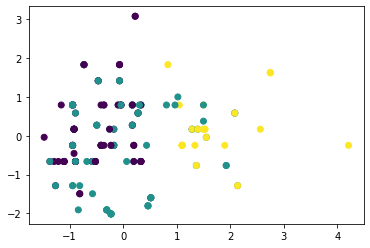

In [18]:
from pyspark.ml.clustering import KMeans
kmeans = KMeans(k=3, seed=1)
model = kmeans.fit(autoDf)
predictions = model.transform(autoDf)
predictions.show()

#Plot the results in a scatter plot
import pandas as pd

def unstripData(instr) :
    return ( instr["prediction"], instr["features"][0], \
        instr["features"][1],instr["features"][2],instr["features"][3])
    
unstripped=predictions.rdd.map(unstripData)
predList=unstripped.collect()
predPd = pd.DataFrame(predList)

import matplotlib.pylab as plt
plt.cla()
plt.scatter(predPd[3],predPd[4], c=predPd[0])